In [91]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score

import sklearn.linear_model
import re
import nltk
from time import time
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
# nltk.download('stopwords')
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))

    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))
    if ax is None:
        ax = plt.gca()
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

In [3]:
def plot_data(X, y):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=(y == 1), cmap=cm_bright)

In [76]:
class NeuralNet:
    """
    NN for binary classification
    Attributes:
    ...
    """
    
    def __init__(self, hidden_layer_sizes, normalize = True, learning_rate = 0.01, num_iter = 30000 , 
                 precision = None, accuracy=0.00001,beta=0.5,epsilon=1e-8):
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
        self.hidden_layer_sizes = hidden_layer_sizes
        self.precision = precision
        self.accuracy = accuracy
        self.n_layers = 1 + len(hidden_layer_sizes)
        self.epsilon = epsilon
        self.beta = beta;
        
    
    def __normalize(self, X, mean = None, std = None):
        n = X.shape[0]        
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X-m)/s**2
        
        return X_new, m, s


    def __sigmoid(self, Z):
        """
        В наступних практичних потрібно буде додати підтримку й інших активаційних функцій - це один з гіперпараметрів. 
        Їх можна вибирати для всіх шарів одночасно або мати різні активаційні функції на кожному з них.
        """
        return 1 / (1 + np.exp(-Z))
       
    def __softmax(self, Z):
        expZ = np.exp(Z - np.max(Z))
        return expZ / expZ.sum(axis=0, keepdims=True)
        
    
    def __initialize_parameters(self, n_x, hidden_layers, n_y):
        np.random.seed(1)
        W = list()
        b = list()
        
        h = list(hidden_layers)
        h.insert(0, n_x)
        h.append(n_y)
        hidden_layers = tuple(h)
        
        for i in range(1, self.n_layers+1):
            W.append(np.random.randn(hidden_layers[i], hidden_layers[i-1]) / np.sqrt(
                hidden_layers[i - 1]))
            b.append(np.zeros((hidden_layers[i], 1)))

        self.parameters = {"W" : W, "b" : b}


    def __forward_propagation(self, X):
        W = self.parameters["W"]
        b = self.parameters["b"]

        A = list()
        Z = list()
               
        for i in range(0, self.n_layers-1):
            if i == 0:
                Z.append(np.dot(W[i], X) + b[i])
            else:
                Z.append(np.dot(W[i], A[i-1]) + b[i])
            A.append(self.__sigmoid(Z[i]))
        
        Z.append(np.dot(W[-1], A[-1]) + b[-1])
        A.append(self.__softmax(Z[-1]))
        
        cache = (W, b, Z, A)

        return A[-1], cache
    
    def __sigmoid_derivative(self, Z):
        s = 1 / (1 + np.exp(-Z))
        return np.multiply(s, (1 - s))
    
    def compute_cost(self, A, Y):
        J = -np.mean(Y.T * np.log(A.T+ 1e-8))
        return J
    
    def __backward_propagation(self, X, Y, cache):
        m = X.shape[1]
        n = X.shape[0]
        (W, b, Z, A) = cache
        
        dW = [None] * (self.n_layers)
        dA = [None] * (self.n_layers)
        dZ = [None] * (self.n_layers)
        db = [None] * (self.n_layers)
        
        dZ[-1] = (A[-1] - Y)
        dW[-1] = (1. / m * np.dot(dZ[-1], A[-2].T))
        db[-1] = (1. / m * np.sum(dZ[-1], axis = 1, keepdims = True))
        dA[-1] = np.dot(W[-1].T, dZ[-1])
        
        for i in range(self.n_layers-1, 0, -1):
            dZ[i-1] = np.multiply(dA[i], self.__sigmoid_derivative(Z[i-1]))
            if i-1 == 0:
                dW[i-1] = 1. / m * np.dot(dZ[i-1], X.T)
            else:
                dW[i-1] = 1. / m * np.dot(dZ[i-1], A[i-2].T)
            db[i-1] = 1. / m * np.sum(dZ[i-1], axis = 1, keepdims = True) 
            dA[i-1] = np.dot(W[i-1].T, dZ[i-1])
        
        grads = {"dZ" : dZ, "dW" : dW, "db" : db}
        return grads


    def __update_parameters(self, grads):
        W = self.parameters["W"]
        b = self.parameters["b"]

        dW = grads["dW"]
        db = grads["db"]
        
        for i in range(self.n_layers):
            self.S_dW[i] = self.beta * self.S_dW[i] + (1 - self.beta) * np.power(dW[i], 2)
            self.S_db[i] = self.beta * self.S_db[i] + (1 - self.beta) * np.power(db[i], 2)
            W[i] = W[i] - self.learning_rate * dW[i] / (np.sqrt(self.S_dW[i]) + self.epsilon)
            b[i] = b[i] - self.learning_rate * db[i] / (np.sqrt(self.S_db[i]) + self.epsilon)
            
        self.parameters = {"W" : W, "b" : b}

    def fit(self, X_vert, Y_vert, print_cost = True):
        self.n_iter = 0
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        check = []
        
        m = X.shape[1]
        n_x = X.shape[0]
        n_y = Y.shape[0]
        
        self.__initialize_parameters(n_x, self.hidden_layer_sizes, n_y)

        self.S_dW = list()
        self.S_db = list()
        h = list(self.hidden_layer_sizes)
        h.insert(0, n_x)
        h.append(n_y)
        hidden_layers = tuple(h)
        for i in range(1, self.n_layers+1):
            self.S_dW.append(np.zeros((hidden_layers[i], hidden_layers[i-1])))
            self.S_db.append(np.zeros((hidden_layers[i], 1)))
        
        for i in range(self.num_iter):
            self.n_iter = i
            A, cache = self.__forward_propagation(X)

            cost = self.compute_cost(A, Y)

            grads = self.__backward_propagation(X, Y, cache)

            self.__update_parameters(grads)
            
            check.append(cost)
            if print_cost and i % 10 == 0:
                print("{}-th iteration: {}".format(i, cost))

            if i % 10 == 0:
                costs.append(cost)
                
            if(len(check)>2 and abs(check[i]-check[i-1])<self.accuracy):
                break

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *1000")
            plt.show()

    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs,cache = self.__forward_propagation(X)
        return probs.T
    
    
    def predict(self, X_vert):
        pp = self.predict_proba(X_vert)
        return np.argmax(pp, axis=1)

In [5]:
HEADERS = [
    'From', 'Subject', 'To', 'Reply-To', 'In-Reply-To', 'Apparently-To',
    'Original-Sender', 'Originator', 'Moderator', 'Organization', 'Keywords',
    'Distribution', 'NNTP-Posting-Host', 'Lines', 'Summary', 'Supersedes',
    'X-Bytes', 'X-Disclaimer', 'X-Mailer', 'X-Newsreader', 'X-News-Reader',
    'X-Gated-By', 'X-Added', 'X-Status',
    'OD-Comment-To', 'Expires', 'Disclaimer', 'Article-I.D.', 
    'News-Software',  'Nf-ID', 'Mime-Version'
]

RE_EMAIL = re.compile('<?.*@.*>?', re.M)
RE_LINE_BREAK = re.compile('\\n+', re.M)
RE_CITATION = re.compile('^.*writes:$', re.M)
RE_CITATION_QUOTES = re.compile('(\W+|^)(\|>|>|\|)+', re.M)
RE_HEADERS = re.compile('^(%s):.*$' % '|'.join(HEADERS), re.M|re.I)
def _clean(docs):
    docs = map(rm_headers, docs)
    docs = map(rm_citation, docs)
    docs = map(rm_citation_quotes, docs)
    docs = map(rm_email, docs)
    docs = map(rm_line_break, docs)
    
    return list(docs)

def rm_citation(doc):
    return RE_CITATION.sub('', doc)

def rm_citation_quotes(doc):
    return RE_CITATION_QUOTES.sub(r'\1', doc)

def rm_email(doc):
    return RE_EMAIL.sub('<email>', doc)

def rm_line_break(doc):
    return RE_LINE_BREAK.sub(' ', doc).strip('\n\t ')

def rm_headers(doc):
    return RE_HEADERS.sub('', doc)

In [7]:
ng = fetch_20newsgroups(subset="all", shuffle=False)
df=pd.DataFrame.from_dict({
        'text': _clean(ng.data),
        'group': np.take(ng.target_names, ng.target)
    })

In [ ]:
df.describe(include='all')

In [ ]:
df.head(100)

In [8]:
train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df.group)

In [9]:
train.group.value_counts()

rec.sport.hockey            799
soc.religion.christian      798
rec.motorcycles             797
rec.sport.baseball          795
sci.crypt                   793
sci.med                     792
rec.autos                   792
sci.space                   790
comp.windows.x              790
comp.os.ms-windows.misc     788
sci.electronics             787
comp.sys.ibm.pc.hardware    786
misc.forsale                780
comp.graphics               778
comp.sys.mac.hardware       770
talk.politics.mideast       752
talk.politics.guns          728
alt.atheism                 639
talk.politics.misc          620
talk.religion.misc          502
Name: group, dtype: int64

In [10]:
label_encoder = LabelEncoder().fit(train.group)

In [11]:
label_encoder.classes_

array(['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc',
       'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
       'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles',
       'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt',
       'sci.electronics', 'sci.med', 'sci.space',
       'soc.religion.christian', 'talk.politics.guns',
       'talk.politics.mideast', 'talk.politics.misc',
       'talk.religion.misc'], dtype=object)

In [12]:
Y_train = label_encoder.transform(train.group)
print('Y_train shape: %s' % (Y_train.shape,))

Y_test = label_encoder.transform(test.group)
print('Y_test shape: %s' % (Y_test.shape,))

Y_train shape: (15076,)
Y_test shape: (3770,)


In [13]:
tfidf = TfidfVectorizer(max_features=10000).fit(train.text)
len(tfidf.vocabulary_)

10000

In [14]:
X_train = tfidf.transform(train.text).toarray()
print('X_train shape: %s' % (X_train.shape,))

X_test = tfidf.transform(test.text).toarray()
print('X_test shape: %s' % (X_test.shape,))

X_train shape: (15076, 10000)
X_test shape: (3770, 10000)


In [15]:
label_encoder = LabelEncoder().fit(train.group)

Y_train = label_encoder.transform(train.group)
print('Y_train shape: %s' % (Y_train.shape,))

Y_test = label_encoder.transform(test.group)
print('Y_test shape: %s' % (Y_test.shape,))

Y_train shape: (15076,)
Y_test shape: (3770,)


# MultinomialNB

In [93]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB().fit(X_train, Y_train)

In [94]:
print(classification_report(Y_train, clf.predict(X_train), target_names=label_encoder.classes_))

                          precision    recall  f1-score   support

             alt.atheism       0.88      0.72      0.79       639
           comp.graphics       0.84      0.85      0.85       778
 comp.os.ms-windows.misc       0.83      0.86      0.85       788
comp.sys.ibm.pc.hardware       0.79      0.88      0.83       786
   comp.sys.mac.hardware       0.92      0.89      0.91       770
          comp.windows.x       0.92      0.88      0.90       790
            misc.forsale       0.90      0.80      0.85       780
               rec.autos       0.91      0.94      0.92       792
         rec.motorcycles       0.96      0.95      0.96       797
      rec.sport.baseball       0.96      0.97      0.97       795
        rec.sport.hockey       0.94      0.98      0.96       799
               sci.crypt       0.91      0.95      0.93       793
         sci.electronics       0.88      0.84      0.86       787
                 sci.med       0.94      0.95      0.95       792
         

In [95]:
print(classification_report(Y_test, clf.predict(X_test), target_names=label_encoder.classes_))

                          precision    recall  f1-score   support

             alt.atheism       0.79      0.58      0.67       160
           comp.graphics       0.72      0.79      0.76       195
 comp.os.ms-windows.misc       0.77      0.77      0.77       197
comp.sys.ibm.pc.hardware       0.69      0.79      0.73       196
   comp.sys.mac.hardware       0.85      0.77      0.81       193
          comp.windows.x       0.84      0.82      0.83       198
            misc.forsale       0.89      0.75      0.81       195
               rec.autos       0.87      0.86      0.86       198
         rec.motorcycles       0.88      0.90      0.89       199
      rec.sport.baseball       0.95      0.95      0.95       199
        rec.sport.hockey       0.93      0.93      0.93       200
               sci.crypt       0.85      0.91      0.88       198
         sci.electronics       0.82      0.77      0.79       197
                 sci.med       0.94      0.88      0.91       198
         

In [96]:
pred = clf.predict(X_test)

In [97]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, pred)

0.806631299734748

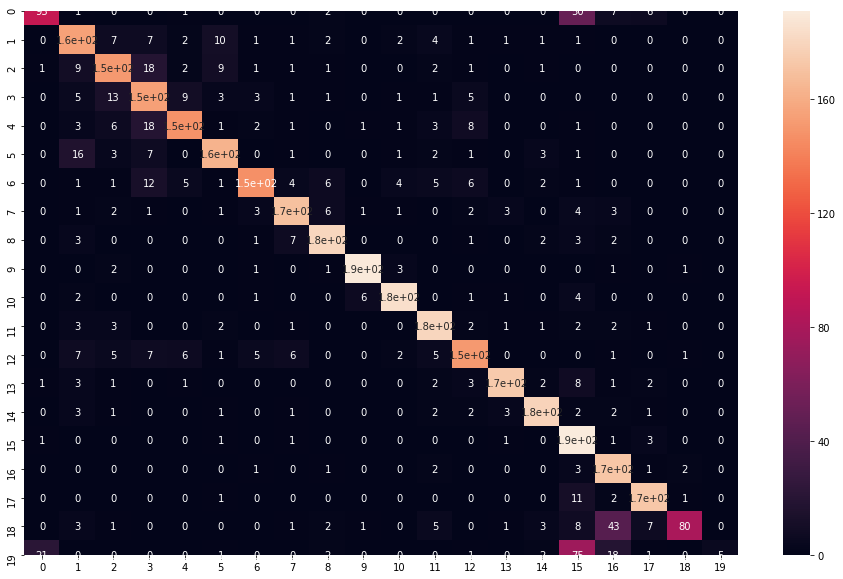

In [98]:
import seaborn as sns
cm = confusion_matrix(Y_test, pred) 
plt.figure(figsize=(16,10))
sns.heatmap(cm,annot=True)
plt.show()

# Custom Classifier

In [82]:
cls = NeuralNet(hidden_layer_sizes = [50,] , normalize = True, learning_rate = 0.001, num_iter = 100, beta = 0.3, epsilon=1e-8, accuracy=0.0001)
    
#cls = NeuralNet(normalize = True, learning_rate = 0.01, 
 #                num_iter = 1000,hidden_layer_sizes=[60,],accuracy=0.00000001,beta=0.8)    

In [83]:
encoder = OneHotEncoder()
Y_train_e = encoder.fit_transform(Y_train.reshape((Y_train.shape[0], 1))).toarray()

0-th iteration: 0.1593559821669858
10-th iteration: 0.11537986257970888
20-th iteration: 0.09479613735830571
30-th iteration: 0.08044653922782923
40-th iteration: 0.06978096583874913
50-th iteration: 0.0605325401270101
60-th iteration: 0.053012478494100915
70-th iteration: 0.046775143073439225


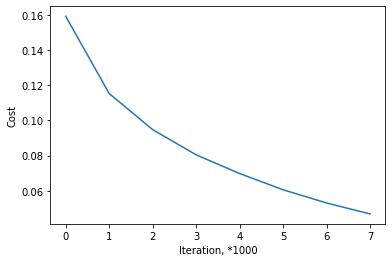

In [84]:
cls.fit(X_train, Y_train_e)

In [85]:
y_train_pred = np.array(cls.predict(X_train))
print(Y_train.shape)
accuracy_ts = accuracy_score(Y_train, y_train_pred)
precision_ts = precision_score(Y_train, y_train_pred, average='micro')
recall_ts = recall_score(Y_train, y_train_pred, average='micro')
print('Accuracy       : ', accuracy_ts)
print('Precision      : ', precision_ts)
print('Recall         : ', recall_ts)

(15076,)
Accuracy       :  0.9376492438312549
Precision      :  0.9376492438312549
Recall         :  0.9376492438312549


In [86]:
print(classification_report(Y_train, y_train_pred,target_names=label_encoder.classes_))

                          precision    recall  f1-score   support

             alt.atheism       0.92      0.88      0.90       639
           comp.graphics       0.84      0.94      0.89       778
 comp.os.ms-windows.misc       0.96      0.89      0.92       788
comp.sys.ibm.pc.hardware       0.93      0.94      0.94       786
   comp.sys.mac.hardware       0.93      0.94      0.94       770
          comp.windows.x       0.92      0.95      0.93       790
            misc.forsale       0.91      0.94      0.92       780
               rec.autos       0.94      0.96      0.95       792
         rec.motorcycles       0.97      0.96      0.97       797
      rec.sport.baseball       0.97      0.98      0.97       795
        rec.sport.hockey       0.97      0.98      0.97       799
               sci.crypt       0.96      0.97      0.96       793
         sci.electronics       0.98      0.85      0.91       787
                 sci.med       0.96      0.94      0.95       792
         

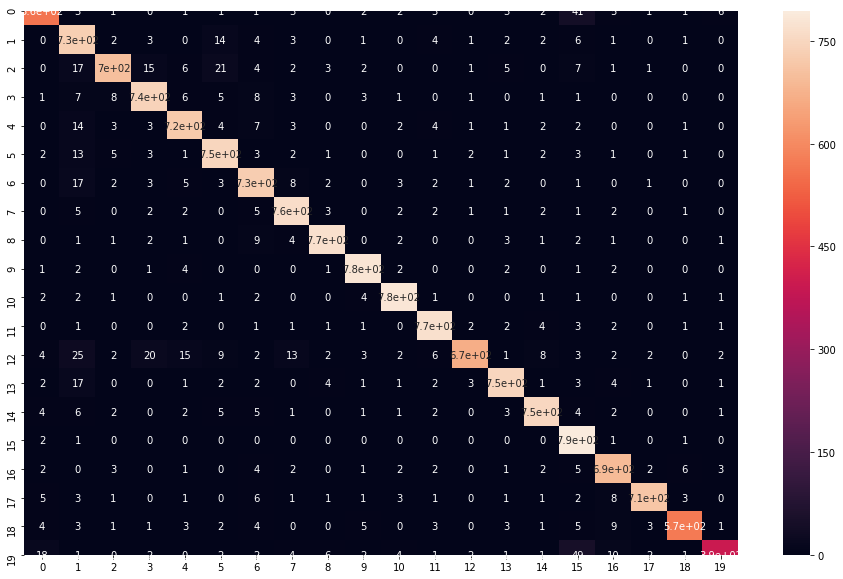

In [92]:
cm = confusion_matrix(Y_train, y_train_pred) 
plt.figure(figsize=(16,10))
sns.heatmap(cm,annot=True)
plt.show()